In [2]:
%env JAX_DISABLE_JIT=False

try:
  import dlfb
except ImportError as exc:
  # NOTE: Packages installed in editable mode are not immediately
  #       recognized by Colab (https://stackoverflow.com/a/63312333).
  import site
  site.main()
  import dlfb

from dlfb.utils.display import display

env: JAX_DISABLE_JIT=False


In [3]:
import py3Dmol
import requests

def fetch_protein_structure(pdb_id: str) -> str:
    """grab a PDB protein structure from the PCSB data bank"""
    url = f"https://files.rcsb.org/download/{pdb_id}.pdb"
    response = requests.get(url)
    return response.text

# the protein data bank (PDB) is the main database of protein structures.
# each structure has a unique 4-character PDB ID. Below are a few examples.
protein_to_pdb = {
    "insulin":"3I40",
    "collagen":"1BKV",
    "proteasome":"1YAR"
}

protein = "collagen"
pdb_structure = fetch_protein_structure(pdb_id=protein_to_pdb[protein])

pdbview = py3Dmol.view(width=400, height=300)
pdbview.addModel(pdb_structure, "pdb")
pdbview.setStyle({"cartoon": {"color" : "spectrum"}})
pdbview.zoomTo()
pdbview.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [4]:
from dlfb.utils.display import print_short_dict
amino_acids = [ "R", "H", "K", "D", "E", "S", "T", "N", "Q", "G", "P", "C", "A", "V", "I", "L", "M", "F", "Y", "W"]

amino_acid_to_index = {
    amino_acid: index for index, amino_acid in enumerate(amino_acids)
}

print_short_dict(amino_acid_to_index)

{'R': 0, 'H': 1, 'K': 2, 'D': 3, 'E': 4, 'S': 5, 'T': 6, 'N': 7, 'Q': 8, 'G': 9}
…(+10 more entries)


In [5]:
# methionine, alanine, leucine, tryptophan, methionine
tiny_protein = ["M", "A", "L", "W", "M"]

tiny_protein_indices = [amino_acid_to_index[amino_acid] for amino_acid in tiny_protein]

tiny_protein_indices

[16, 12, 15, 19, 16]

[Text(0.5, 146.32222222222222, 'Amino Acid Index'),
 Text(50.722222222222214, 0.5, 'Protein Sequence')]

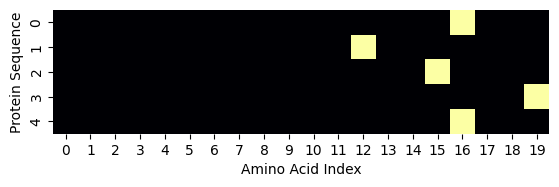

In [6]:
import jax

one_hot_encoded_sequence = jax.nn.one_hot(
    x=tiny_protein_indices, num_classes=len(amino_acids)
)

import seaborn as sns
fig = sns.heatmap(one_hot_encoded_sequence, square=True, cbar=False, cmap="inferno")
fig.set(xlabel="Amino Acid Index", ylabel="Protein Sequence")

In [7]:
from transformers import AutoTokenizer, EsmModel

#model checkpoint name taken from this github readme: etc
model_checkpoint = "facebook/esm2_t33_650M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = EsmModel.from_pretrained(model_checkpoint)

vocab_to_index = tokenizer.get_vocab()
print_short_dict(vocab_to_index)

c:\Users\justc\anaconda3\envs\dl4b\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'<cls>': 0, '<pad>': 1, '<eos>': 2, '<unk>': 3, 'L': 4, 'A': 5, 'G': 6, 'V': 7,
'S': 8, 'E': 9}
…(+23 more entries)


In [8]:
tokenized_tiny_protein = tokenizer("MALWM")["input_ids"]
tokenized_tiny_protein[1:-1]

[20, 5, 4, 22, 20]

In [9]:
token_embeddings = model.get_input_embeddings().weight.detach().numpy()
token_embeddings.shape

(33, 1280)

In [10]:
import pandas as pd
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(token_embeddings)
embeddings_tsne_df = pd.DataFrame(embeddings_tsne, columns=["first_dim", "second_dim"])
embeddings_tsne_df.shape

(33, 2)

Text(0, 0.5, 'Second Dimentsion')

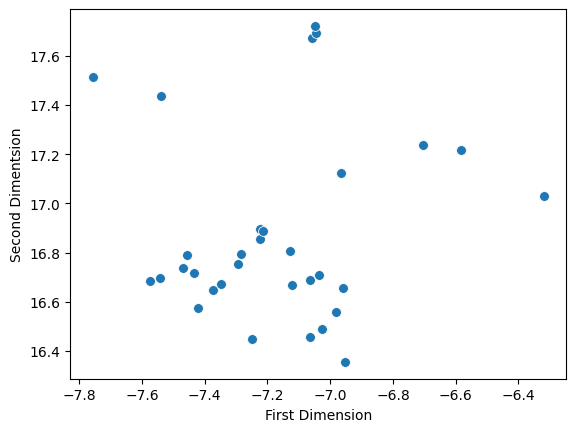

In [11]:
import seaborn as sns
fig = sns.scatterplot(
    data=embeddings_tsne_df, x="first_dim", y="second_dim", s=50
)
fig.set_xlabel("First Dimension")
fig.set_ylabel("Second Dimentsion")

# let's color the t-SNE projection by amino acid properties reveals clear clusters of amino acids with similar biochemical roles that tend to group together in embedding space, reflecting the model's ability to capture meaningful biological structure. technical non-amino acid tokens also group together in this latent space.

([Text(-7.667293499320025, 17.558232250667757, '<cls>'),
  Text(-6.948289268986593, 17.627360400699434, '<pad>'),
  Text(-7.442401329433967, 17.48158353850955, '<eos>'),
  Text(-6.658246524732921, 17.67363809403919, '<unk>'),
  Text(-7.102059385961583, 16.7058139528547, 'L'),
  Text(-7.258246379345656, 16.83220641953605, 'A'),
  Text(-7.461588746561639, 16.766359420049756, 'G'),
  Text(-7.095453001719809, 16.818035023553033, 'V'),
  Text(-7.27150278733142, 16.74304701033093, 'S'),
  Text(-7.443429991380581, 16.85247370174953, 'E'),
  Text(-7.3239547959631, 16.628323804764523, 'R'),
  Text(-7.0459317436598, 16.66430031685602, 'T'),
  Text(-7.0213070773309285, 16.75936467306955, 'I'),
  Text(-7.570500700856529, 16.743477560224985, 'D'),
  Text(-7.51456224498369, 16.75858637264797, 'P'),
  Text(-7.410663825129309, 16.72172977810814, 'K'),
  Text(-7.323422002798368, 16.73803147815523, 'Q'),
  Text(-7.394112087947226, 16.565315995897567, 'N'),
  Text(-7.003716801200062, 16.518865528560823, 

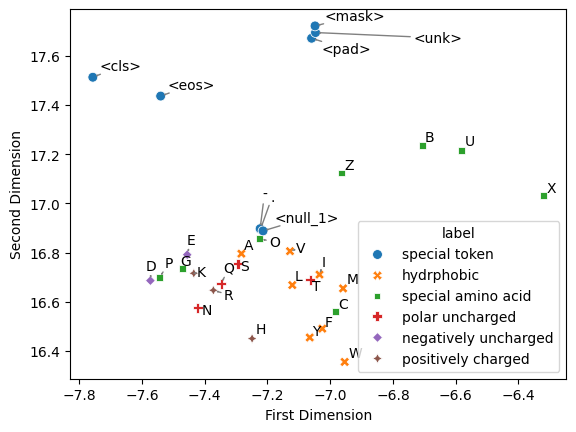

In [12]:
from adjustText import adjust_text

embeddings_tsne_df["token"] = list(vocab_to_index.keys())

token_annotation = {
    "hydrphobic": ["A", "F", "I", "L", "M", "V", "W", "Y"],
    "polar uncharged": ["N", "Q", "S", "T"],
    "negatively uncharged":["D", "E"],
    "positively charged":["H", "K", "R"],
    "special amino acid":["B", "C", "G", "O", "P", "U", "X", "Z"],
    "special token" : [
        "-",
        ".",
        "<cls>",
        "<eos>",
        "<mask>",
        "<null_1>",
        "<pad>",
        "<unk>",
    ],
}

embeddings_tsne_df["label"] = embeddings_tsne_df["token"].map({t: label for label, tokens in token_annotation.items() for t in tokens})

fig = sns.scatterplot(
    data=embeddings_tsne_df,
    x="first_dim",
    y="second_dim",
    hue="label",
    style="label",
    s=50,
)
fig.set_xlabel("First Dimension")
fig.set_ylabel("Second Dimension")
texts = [
    fig.text(point["first_dim"], point["second_dim"], point["token"]) 
    for _, point in embeddings_tsne_df.iterrows()
]
adjust_text(
    texts, expand=(1.5, 1.5), arrowprops=dict(arrowstyle="->", color="grey")
)

In [13]:
insulin_sequence =  (
    "MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGG"
    "GPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN"
) 

In [14]:
masked_insulin_sequence = (
    "MALWMRLLPLLALLALWGPDPAAAFVNQH<mask>CGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGG"
    "GPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN"
) #maksed insulin's 29th seq. L
masked_inputs = tokenizer(masked_insulin_sequence)["input_ids"]
assert masked_inputs[30] == vocab_to_index["<mask>"]

In [15]:
from transformers import EsmForMaskedLM

model_checkpoint = "facebook/esm2_t30_150M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
masked_lm_model = EsmForMaskedLM.from_pretrained(model_checkpoint)

import matplotlib.pyplot as plt

model_outputs = masked_lm_model(
    **tokenizer(text=masked_insulin_sequence, return_tensors="pt")
)

Text(0.5, 1.0, 'Model Probabilities for the Masked Amino Acid')

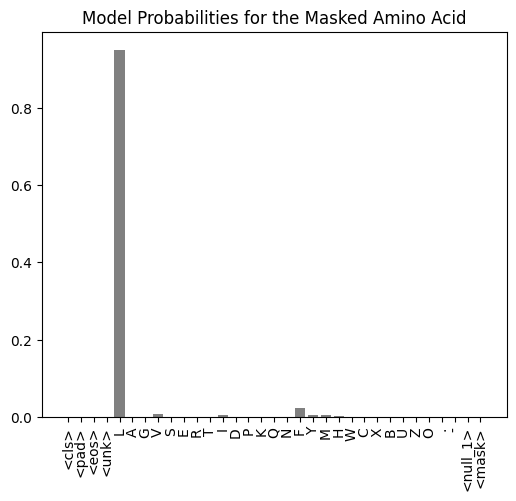

In [16]:
model_preds = model_outputs.logits
mask_preds = model_preds[0, 30].detach().numpy()
mask_probs = jax.nn.softmax(mask_preds)
letters = list(vocab_to_index.keys())
fig, ax = plt.subplots(figsize=(6,5))
plt.bar(letters, mask_probs, color="grey")
plt.xticks(rotation=90)
plt.title("Model Probabilities for the Masked Amino Acid")

In [17]:
from matplotlib.figure import Figure
from transformers import PreTrainedModel, PreTrainedTokenizer
import jax
class MaskPredictor:
    """predict masked amino acids using a protein language model"""
    def __init__(self, tokenizer: PreTrainedTokenizer, model: PreTrainedModel):
        """initialize with a tokenizer and pretrained model"""
        self.tokenizer = tokenizer
        self.model = model

    def plot_predictions(self, sequence: str, mask_index: int):
        """plot predicted probabilities for the masked amino acid"""
        mask_probs = self.predict(sequence, mask_index) # type: ignore
        fig, _ = plt.subplots(figsize=(6, 4))
        plt.xticks(rotation=90)
        plt.bar(list(self.tokenizer.get_vocab().keys()), mask_probs, color="grey")
        
        plt.title("Model Probabilities for the masked amino acid\n"
                  f"at Index={mask_index} (True Amino Acid = {sequence[mask_index]}).")
        return fig
    
    def predict(self, sequence:str, mask_index: int):
        """return model probabilities for masked amino acid at a position"""
        masked_sequence = self.mask_sequence(sequence, mask_index)
        masked_inputs = self.tokenizer(masked_sequence, return_tensors="pt")
        model_outputs = self.model(**masked_inputs)
        mask_preds = model_outputs.logits[0, mask_index + 1].detach().numpy()
        mask_probs = jax.nn.softmax(mask_preds)
        return mask_probs
    
    @staticmethod
    def mask_sequence(sequence: str, mask_index: int) :
        """insert mask token at specified index in the input sequence"""
        if mask_index < 0 or mask_index > len(sequence):
            raise ValueError("mask index outside of sequence range.")
        return f"{sequence[0:mask_index]}<mask>{sequence[(mask_index + 1):]}"



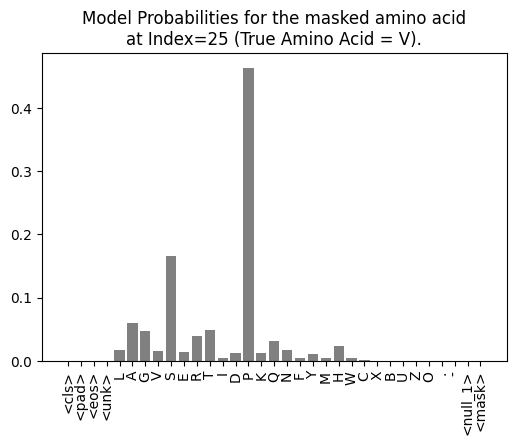

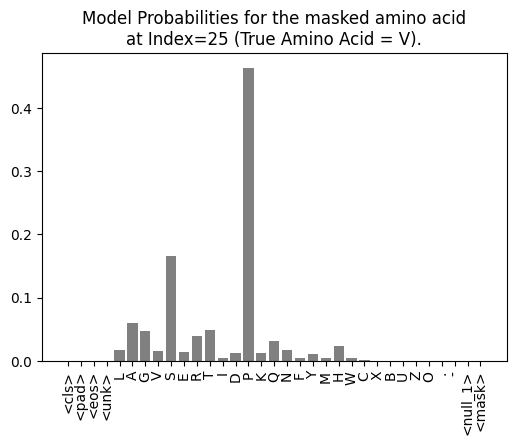

In [18]:
MaskPredictor(tokenizer, model=masked_lm_model).plot_predictions(sequence=insulin_sequence, mask_index=25)

# Extracellular versus membrane protein embeddings

In [19]:
import pandas as pd
from dlfb.utils.context import assets

protein_df = pd.read_csv(r"C:\Users\justc\Documents\ml-study-notes\ml-study-notes\dlfb-clone\assets\proteins\datasets\sequence_df_cco.csv")
protein_df = protein_df[~protein_df["term"].isin(["GO:0005575", "GO:0110165"])]
num_proteins = protein_df["EntryID"].nunique()
print(protein_df)

       EntryID                                           Sequence  taxonomyID  \
0       O95231  MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...        9606   
1       O95231  MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...        9606   
2       O95231  MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...        9606   
3       O95231  MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...        9606   
5       O95231  MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...        9606   
...        ...                                                ...         ...   
337549  E7ER32  MPPLKSPAAFHEQRRSLERARTEDYLKRKIRSRPERSELVRMHILE...        9606   
337550  E7ER32  MPPLKSPAAFHEQRRSLERARTEDYLKRKIRSRPERSELVRMHILE...        9606   
337551  E7ER32  MPPLKSPAAFHEQRRSLERARTEDYLKRKIRSRPERSELVRMHILE...        9606   
337552  E7ER32  MPPLKSPAAFHEQRRSLERARTEDYLKRKIRSRPERSELVRMHILE...        9606   
337553  E7ER32  MPPLKSPAAFHEQRRSLERARTEDYLKRKIRSRPERSELVRMHILE...        9606   

              term aspect  

In [20]:
# filter protein dataframe to proteins with a single location
num_locations = protein_df.groupby("EntryID")["term"].nunique()
proteins_one_location = num_locations[num_locations == 1].index

In [21]:
protein_df = protein_df[protein_df["EntryID"].isin(proteins_one_location)]
go_function_examples = {
    "extracellular" : "GO:0005576",
    "membrane": "GO:0016020",
}

sequences_by_function = {}
min_length = 100
max_length = 500
num_samples = 20

for function, go_term in go_function_examples.items():
    proteins_with_function = protein_df[
        (protein_df["term"] == go_term)
        & (protein_df["Length"] >= min_length)
        & (protein_df["Length"] <= max_length)
    ]
    print(
        f"found {len(proteins_with_function)} human proteins\n"
        f"with the molecular function '{function}' ({go_term}).\n"
        f"and {min_length}<=length<={max_length}\n"
        f"sampling {num_samples} proteins at random. \n"
    )
    sequences = list(proteins_with_function.sample(num_samples, random_state=42, replace=True)["Sequence"])
    sequences_by_function[function] = sequences


found 164 human proteins
with the molecular function 'extracellular' (GO:0005576).
and 100<=length<=500
sampling 20 proteins at random. 

found 65 human proteins
with the molecular function 'membrane' (GO:0016020).
and 100<=length<=500
sampling 20 proteins at random. 



In [22]:
import torch
import numpy as np
from dlfb.proteins.utils import get_device

def get_mean_embeddings(
        sequences: list[str],
        tokenizer: PreTrainedTokenizer,
        model: PreTrainedModel,
        device: torch.device | None = None,
):
    if not device:
        device = get_device()
    
    # tokenize input sequences and pad them to equal length.
    model_inputs = tokenizer(sequences, padding=True, return_tensors="pt")

    #move tokenized inputs to the target device (CPU in my case)
    model_inputs = {k: v.to(device) for k, v in model_inputs.items()}
    
    model = model.to(device) # type: ignore
    model.eval()

    #forward pass without gradient tracking to obtain embeddings
    with torch.no_grad():
        outputs = model(**model_inputs)
        mean_embeddings = outputs.last_hidden_state.mean(dim=1)
    
    return mean_embeddings.detach().cpu().numpy()
    

In [23]:
model_checkpoint = "facebook/esm2_t6_8M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = EsmModel.from_pretrained(model_checkpoint)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# compute mean protein embeddings for each location
protein_embeddings = {
    loc: get_mean_embeddings(sequences_by_function[loc], tokenizer, model)
    for loc in ["extracellular", "membrane"]
}

# reformat data.
labels, embeddings = [], []
for location, embedding in protein_embeddings.items():
    labels.extend([location] * embedding.shape[0])
    embeddings.append(embedding)
    print(f"{location}: {embedding.shape}")

extracellular: (20, 320)
membrane: (20, 320)


Text(0, 0.5, 'Second Dimension')

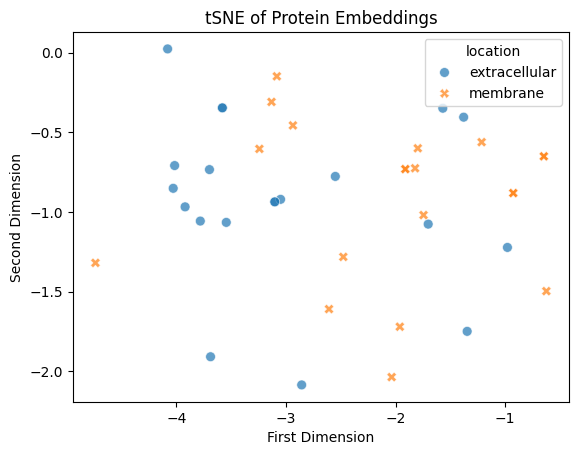

In [25]:
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE

embeddings_tsne = TSNE(n_components = 2, random_state=42).fit_transform(np.vstack(embeddings))
embeddings_tsne_df = pd.DataFrame(
    {
        "first_dimension": embeddings_tsne[:, 0],
        "second_dimension": embeddings_tsne[:, 1],
        "location": np.array(labels)
    }
)

fig = sns.scatterplot(
    data = embeddings_tsne_df,
    x="first_dimension",
    y="second_dimension",
    hue="location",
    style="location",
    s=50,
    alpha=0.7,
)
plt.title("tSNE of Protein Embeddings")
fig.set_xlabel("First Dimension")
fig.set_ylabel("Second Dimension")

In [26]:
labels = pd.read_csv(
    r"C:\Users\justc\Documents\ml-study-notes\ml-study-notes\dlfb-clone\assets\proteins\datasets\train_terms.tsv.zip", sep="\t", compression="infer"
)
print(labels)

            EntryID        term aspect
0        A0A009IHW8  GO:0008152    BPO
1        A0A009IHW8  GO:0034655    BPO
2        A0A009IHW8  GO:0072523    BPO
3        A0A009IHW8  GO:0044270    BPO
4        A0A009IHW8  GO:0006753    BPO
...             ...         ...    ...
5363858      X5L565  GO:0050649    MFO
5363859      X5L565  GO:0016491    MFO
5363860      X5M5N0  GO:0005515    MFO
5363861      X5M5N0  GO:0005488    MFO
5363862      X5M5N0  GO:0003674    MFO

[5363863 rows x 3 columns]


In [27]:
import obonet
import os

def get_go_term_descriptions(store_path: str):
    """return GO term to description mapping, downloading if needed"""
    if not os.path.exists(store_path):
        url = "https://current.geneontology.org/ontology/go-basic.obo"
        graph = obonet.read_obo(url)

        # Extract GO term IDs and names from the graph nodes
        id_to_name = {id: data.get("name") for id, data in graph.nodes(data=True)}
        go_term_descriptions = pd.DataFrame(
            zip(id_to_name.keys(), id_to_name.values()),
            columns=["term", "description"]
        )
        go_term_descriptions.to_csv(store_path, index=False)

    else:
        go_term_descriptions = pd.read_csv(store_path)
        
    return go_term_descriptions

c:\Users\justc\anaconda3\envs\dl4b\Lib\site-packages\obonet\__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [28]:
go_term_descriptions = get_go_term_descriptions(
    store_path=r"C:\Users\justc\Documents\ml-study-notes\ml-study-notes\dlfb-clone\assets\proteins\datasets\go_term_descriptions.csv"
)
print(go_term_descriptions)

             term                                        description
0      GO:0000001                          mitochondrion inheritance
1      GO:0000002                   mitochondrial genome maintenance
2      GO:0000006  high-affinity zinc transmembrane transporter a...
3      GO:0000007  low-affinity zinc ion transmembrane transporte...
4      GO:0000009             alpha-1,6-mannosyltransferase activity
...           ...                                                ...
40209  GO:2001313  UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...
40210  GO:2001314  UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...
40211  GO:2001315  UDP-4-deoxy-4-formamido-beta-L-arabinopyranose...
40212  GO:2001316                       kojic acid metabolic process
40213  GO:2001317                    kojic acid biosynthetic process

[40214 rows x 2 columns]


In [29]:
labels = labels.merge(go_term_descriptions, on="term")
labels

,EntryID,term,aspect,description
0,A0A009IHW8,GO:0008152,BPO,metabolic process
1,A0A009IHW8,GO:0034655,BPO,nucleobase-containing compound catabolic process
2,A0A009IHW8,GO:0072523,BPO,purine-containing compound catabolic process
3,A0A009IHW8,GO:0006753,BPO,nucleoside phosphate metabolic process
4,A0A009IHW8,GO:1901292,BPO,nucleoside phosphate catabolic process
...,...,...,...,...
4933953,X5L565,GO:0050649,MFO,testosterone 6-beta-hydroxylase activity
4933954,X5L565,GO:0016491,MFO,oxidoreductase activity
4933955,X5M5N0,GO:0005515,MFO,protein binding
4933956,X5M5N0,GO:0005488,MFO,binding


We want to look at MFO (molecualr functions) - how protein does at biochemical level. Later, I might extend this approach to other two categories also.

In [30]:
labels = labels[labels["aspect"] == "MFO"]
print(labels)

            EntryID        term aspect  \
4279022  A0A009IHW8  GO:0003674    MFO   
4279023  A0A009IHW8  GO:0003953    MFO   
4279024  A0A009IHW8  GO:0016787    MFO   
4279025  A0A009IHW8  GO:0016799    MFO   
4279026  A0A009IHW8  GO:0016798    MFO   
...             ...         ...    ...   
4933953      X5L565  GO:0050649    MFO   
4933954      X5L565  GO:0016491    MFO   
4933955      X5M5N0  GO:0005515    MFO   
4933956      X5M5N0  GO:0005488    MFO   
4933957      X5M5N0  GO:0003674    MFO   

                                               description  
4279022                                 molecular_function  
4279023                         NAD+ nucleosidase activity  
4279024                                 hydrolase activity  
4279025  hydrolase activity, hydrolyzing N-glycosyl com...  
4279026       hydrolase activity, acting on glycosyl bonds  
...                                                    ...  
4933953           testosterone 6-beta-hydroxylase activity  
4933954

In [31]:
from Bio import SeqIO
import pandas as pd
sequences_file = r"C:\Users\justc\Documents\ml-study-notes\ml-study-notes\dlfb-clone\assets\proteins\datasets\train_sequences.fasta"
fasta_sequences = SeqIO.parse(open(sequences_file), "fasta")

data = []
for fasta in fasta_sequences:
    data.append(
        {
            "EntryID": fasta.id,
            "Sequence": str(fasta.seq),
            "Length": len(fasta.seq),
        }
    )
sequence_df = pd.DataFrame(data)
print(sequence_df)

           EntryID                                           Sequence  Length
0           P20536  MNSVTVSHAPYTITYHDDWEPVMSQLVEFYNEVASWLLRDETSPIP...     218
1           O73864  MTEYRNFLLLFITSLSVIYPCTGISWLGLTINGSSVGWNQTHHCKL...     354
2           O95231  MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...     258
3       A0A0B4J1F4  MGGEAGADGPRGRVKSLGLVFEDESKGCYSSGETVAGHVLLEAAEP...     415
4           P54366  MVETNSPPAGYTLKRSPSDLGEQQQPPRQISRSPGNTAAYHLTTAM...     415
...            ...                                                ...     ...
142241  A0A286YAI0  METEVDDFPGKASIFSQVNPLYSNNMKLCEAERYDFQHSEPKTMKS...     450
142242  A0A1D5NUC4  MSAAASAEMIETPPVLNFEEIDYKEIEVEEVVGRGAFGVVCKAKWR...     643
142243      Q5RGB0  MADKGPILTSVIIFYLSIGAAIFQILEEPNLNSAVDDYKNKTNNLL...     448
142244  A0A2R8QMZ5  MGRKKIQITRIMDERNRQVTFTKRKFGLMKKAYELSVLCDCEIALI...     459
142245  A0A8I6GHU0  HCISSLKLTAFFKRSFLLSPEKHLVLLRDGRTLIGFLRSIDQFANL...     138

[142246 rows x 3 columns]


In [32]:
taxonomy_file = r"C:\Users\justc\Documents\ml-study-notes\ml-study-notes\dlfb-clone\assets\proteins\datasets\train_taxonomy.tsv.zip"
taxonomy = pd.read_csv(taxonomy_file, sep="\t", compression="infer")
print(taxonomy)

           EntryID  taxonomyID
0           Q8IXT2        9606
1           Q04418      559292
2           A8DYA3        7227
3           Q9UUI3      284812
4           Q57ZS4      185431
...            ...         ...
142241      Q5TD07        9606
142242      A8BB17        7955
142243  A0A2R8QBB1        7955
142244      P0CT72      284812
142245      Q9NZ43        9606

[142246 rows x 2 columns]


In [33]:
sequence_df = sequence_df.merge(
    taxonomy, 
    on="EntryID"
)

# Then filter for human proteins
sequence_df = sequence_df[sequence_df["taxonomyID"] == 9606]

# Then merge with labels
sequence_df = sequence_df.merge(labels, on="EntryID")
print(
    f'Dataset contains {sequence_df["EntryID"].nunique()} human proteins '
    f'with {sequence_df["term"].nunique()} molecular functions.'
)

Dataset contains 16336 human proteins with 4101 molecular functions.


In [34]:
print(sequence_df)

       EntryID                                           Sequence  Length  \
0       O95231  MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...     258   
1       O95231  MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...     258   
2       O95231  MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...     258   
3       O95231  MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...     258   
4       O95231  MRLSSSPPRGPQQLSSFGSVDWLSQSSCSGPTHTPRPADFSLGSLP...     258   
...        ...                                                ...     ...   
152521  Q549H9  MMEVESSYSDFISCDRTGRRNAVPDIQGDSEAVSVRKLAGDMGELA...      76   
152522  Q549H9  MMEVESSYSDFISCDRTGRRNAVPDIQGDSEAVSVRKLAGDMGELA...      76   
152523  Q86TI6  MGAAAVRWHLCVLLALGTRGRLAGGSGLPGSVDVDECSEGTDDCHI...     347   
152524  Q86TI6  MGAAAVRWHLCVLLALGTRGRLAGGSGLPGSVDVDECSEGTDDCHI...     347   
152525  Q86TI6  MGAAAVRWHLCVLLALGTRGRLAGGSGLPGSVDVDECSEGTDDCHI...     347   

        taxonomyID        term aspect  \
0             9606  GO:0003676    

Text(0.5, 1.0, 'DIstribution of function counts per protein')

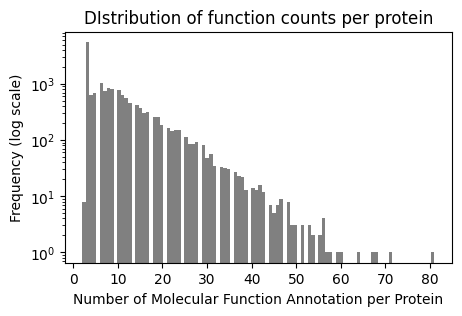

In [35]:
sequence_df.groupby("EntryID")["term"].nunique().plot.hist(
    bins=100, figsize=(5, 3), color="grey", log=True
)
plt.xlabel("Number of Molecular Function Annotation per Protein")
plt.ylabel("Frequency (log scale)")
plt.title("DIstribution of function counts per protein")


In [36]:
uninteresting_functions = [
    "GO:0003674", # "molecular function". applies to 100% of proteins.
    "GO:0005488", # "binding". applies to 93% of proteins.
    "GO:0005515", # "protein binding". applies to 89% of proteins
]

sequence_df = sequence_df[~sequence_df["term"].isin(uninteresting_functions)]
sequence_df.shape

(106501, 7)

In [37]:
common_functions = (
    sequence_df["term"]
    .value_counts()[sequence_df["term"].value_counts() >= 50]
    .index
)

sequence_df = sequence_df[sequence_df["term"].isin(common_functions)]
sequence_df["term"].value_counts()

term
GO:0003824    3875
GO:1901363    2943
GO:0003676    2469
GO:0042802    1803
GO:0016740    1652
              ... 
GO:0005230      52
GO:0031490      51
GO:0005516      51
GO:0015179      50
GO:0019003      50
Name: count, Length: 303, dtype: int64

In [38]:
sequence_df = (
    sequence_df[["EntryID", "Sequence", "Length", "term"]]
    .assign(value=1)
    .pivot(
        index=["EntryID", "Sequence", "Length"], columns="term", values="value"
    )
    .fillna(0)
    .astype(int)
    .reset_index()
)
print(sequence_df)

term      EntryID                                           Sequence  Length  \
0      A0A024R6B2  MIASCLCYLLLPATRLFRALSDAFFTCRKNVLLANSSSPQVEGDFA...     670   
1      A0A087WUI6  MSRKISKESKKVNISSSLESEDISLETTVPTDDISSSEEREGKVRI...     698   
2      A0A087X1C5  MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...     515   
3      A0A0C4DG62  MAHVGSRKRSRSRSRSRGRGSEKRKKKSRKDTSRNCSASTSQERSK...     218   
4      A0A0C4DGF1  MSLPPIRLPSPYGSDRLVQLAARLRPALCDTLITVGSQEFPAHSLV...     302   
...           ...                                                ...     ...   
10704      Q9Y6Y8  MAERKPNGGSGGASTSSSGTNLLFSSSATEFSFNVPFIPVTQASAS...    1000   
10705      Q9Y6Y9  MLPFLFFSTLFSSIFTEAQKQYWVCNSSDASISYTYCDKMQYPISI...     160   
10706      Q9Y6Z7  MNGFASLLRRNQFILLVLFLLQIQSLGLDIDSRPTAEVCATHTISP...     277   
10707      X5D778  MPKGGCPKAPQQEELPLSSDMVEKQTGKKDKDKVSLTKTPKLERGD...     421   
10708      X5D7E3  MLDLTSRGQVGTSRRMAEAACSAHFLETTPTPNPPTTEEEKTESNQ...     237   

term   GO:0000166  GO:0000287  GO:00009

In [39]:
# sanity checks
sequence_df["EntryID"].nunique()

10709

In [40]:
sequence_df["Sequence"].nunique()

10698

In [41]:
print(sequence_df[sequence_df["EntryID"].isin(["P0DP23", "P0DP24", "P0DP25"])]) # proteins with diff Uniprot identifiers but identical sequences! = legitimate

term EntryID                                           Sequence  Length  \
1945  P0DP23  MADQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTE...     149   
1946  P0DP24  MADQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTE...     149   
1947  P0DP25  MADQLTEEQIAEFKEAFSLFDKDGDGTITTKELGTVMRSLGQNPTE...     149   

term  GO:0000166  GO:0000287  GO:0000976  GO:0000977  GO:0000978  GO:0000981  \
1945           0           0           0           0           0           0   
1946           0           0           0           0           0           0   
1947           0           0           0           0           0           0   

term  GO:0000987  ...  GO:0140677  GO:0140678  GO:1901265  GO:1901363  \
1945           0  ...           1           1           0           0   
1946           0  ...           1           1           0           0   
1947           0  ...           1           0           0           0   

term  GO:1901681  GO:1901702  GO:1901981  GO:1902936  GO:1990782  GO:1990837  
1945  

# For memory & time purpose, we roughly halve the data by the length constraint <= 500

In [42]:
print(sequence_df.shape)
sequence_df = sequence_df[sequence_df["Length"] <= 500]
print(sequence_df.shape)

(10709, 306)
(5957, 306)


Splitting the Dataset into Subsets: Training set, Validation set, Test set

In [43]:
from sklearn.model_selection import train_test_split
train_sequence_ids, valid_test_sequence_ids = train_test_split(
    list(set(sequence_df["EntryID"])), test_size=0.40, random_state=42
)
# split the remaining 40% evenly between validation and test sets
valid_sequence_ids, test_sequence_ids = train_test_split(
    valid_test_sequence_ids, test_size=0.50, random_state=42
)
sequence_splits = {
    "train": sequence_df[sequence_df["EntryID"].isin(train_sequence_ids)],
    "valid": sequence_df[sequence_df["EntryID"].isin(valid_sequence_ids)],
    "test": sequence_df[sequence_df["EntryID"].isin(test_sequence_ids)],
}
for split, df in sequence_splits.items():
    print(f"{split} has {len(df)} entries.")


train has 3574 entries.
valid has 1191 entries.
test has 1192 entries.


Converting Protein Sequences into Their Mean Embeddings

In [44]:
from numpy import ceil

def store_sequence_embeddings(
        sequence_df: pd.DataFrame,
        store_prefix: str,
        tokenizer: PreTrainedTokenizer,
        model: PreTrainedModel,
        batch_size: int = 64,
        force: bool = False,
) -> None:
    """extract and store mean embeddings for each protein sequence"""
    model_name = str(model.name_or_path).replace("/", "_")
    store_file = f"{store_prefix}_{model_name}.feather"

    if not os.path.exists(store_file) or force:
        device = get_device()

        #iterate through protein dataframe in batches, extracting embeddings.
        n_batches = ceil(sequence_df.shape[0] / batch_size)
        batches: list[np.ndarray] = []
        for i in range(n_batches):
            batch_seqs = list(
                sequence_df["Sequence"][i * batch_size : (i + 1) * batch_size]
            )
            batches.extend(get_mean_embeddings(batch_seqs, tokenizer, model, device))

        #store each of the embedding values in a separate column in the dataframe
        embeddings = pd.DataFrame(np.vstack(batches))
        embeddings.columns = [f"ME:{int(i)+1}" for i in range(embeddings.shape[1])]
        df = pd.concat([sequence_df.reset_index(drop=True), embeddings], axis=1)
        df.to_feather(store_file)

def load_sequence_embeddings(
            store_file_prefix: str, model_checkpoint: str 
    ):
        model_name = model_checkpoint.replace("/", "_")
        store_file = f"{store_file_prefix}_{model_name}.feather"
        return pd.read_feather(store_file)
    
model_checkpoint = "facebook/esm2_t30_150M_UR50D"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = EsmModel.from_pretrained(model_checkpoint)

for split, df in sequence_splits.items():
    store_sequence_embeddings(
        sequence_df = df,
        store_prefix = f"C:/Users/justc/Documents/ml-study-notes/ml-study-notes/dlfb-clone/assets/proteins/datasets/protein_dataset_{split}",
        tokenizer = tokenizer,
        model = model,
    )

train_df = load_sequence_embeddings(
     r"C:/Users/justc/Documents/ml-study-notes/ml-study-notes/dlfb-clone/assets/proteins/datasets/protein_dataset_train", model_checkpoint=model_checkpoint,
)
print(train_df)
        

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t30_150M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


         EntryID                                           Sequence  Length  \
0     A0A0C4DG62  MAHVGSRKRSRSRSRSRGRGSEKRKKKSRKDTSRNCSASTSQERSK...     218   
1     A0A1B0GTB2   MVITSENDEDRGGQEKESKEESVLAMLGIIGTILNLIVIIFVYIYTTL      48   
2         A0AVI4  MDSPEVTFTLAYLVFAVCFVFTPNEFHAAGLTVQNLLSGWLGSEDA...     362   
3         A0PJW6  MAAPWRRWPTGLLAVLRPLLTCRPLQGTTLQRDVLLFEHDRGRFFT...     202   
4         A1L167  MKELQDIARLSDRFISVELVDESLFDWNVKLHQVDKDSVLWQDMKE...     161   
...          ...                                                ...     ...   
3569      Q9Y6N5  MVPLVAVVSGPRAQLFACLLRLGTQQVGPLQLHTGASHAARNHYEV...     450   
3570      Q9Y6P5  MRLAAAANEAYTAPLAVSGLLGCKQCGGGRDQDEELGIRIPRPLGQ...     492   
3571      Q9Y6W5  MPLVTRNIEPRHLCRQTLPSVRSELECVTNITLANVIRQLGSLSKY...     498   
3572      Q9Y6W6  MPPSPLDDRVVVALSRPVRPQDLNLCLDSSYLGSANPGSNSHPPVI...     482   
3573      Q9Y6Y9  MLPFLFFSTLFSSIFTEAQKQYWVCNSSDASISYTYCDKMQYPISI...     160   

      GO:0000166  GO:0000287  GO:0000976  GO:000097

In [45]:
import tensorflow as tf 

def convert_to_tfds(
        df: pd.DataFrame,
        embeddings_prefix: str = "ME:",
        target_prefix: str = "GO:",
        is_training: bool = False,
        shuffle_buffer: int = 50,
) -> tf.data.Dataset:
    """convert embedding dataframe into a tf dataset."""
    dataset = tf.data.Dataset.from_tensor_slices(
        {
            "embedding": df.filter(regex=f"^{embeddings_prefix}").to_numpy(),
            "target": df.filter(regex=f"^{target_prefix}").to_numpy()
        } # type: ignore
    )
    if is_training:
        dataset = dataset.shuffle(shuffle_buffer).repeat()
    return dataset


In [46]:
train_ds = convert_to_tfds(train_df, is_training=True)

In [47]:
batch_size = 32
batch = next(train_ds.batch(batch_size).as_numpy_iterator())
batch["embedding"].shape, batch["target"].shape

((32, 640), (32, 303))

In [48]:
def build_dataset(
        store_file_prefix: str, model_checkpoint: str
) -> dict[str, tf.data.Dataset]:
    """build train/valid/test tensorflow datasets from stored embeddings"""
    dataset_splits = {}
    for split in ["train", "valid", "test"]:
        dataset_splits[split] = convert_to_tfds(
            df = load_sequence_embeddings(
                store_file_prefix=f"{store_file_prefix}_{split}",
                model_checkpoint=model_checkpoint
            ),
            is_training=(split == "train")
        )
    return dataset_splits

In [49]:
dataset_splits = build_dataset(
    r"C:\Users\justc\Documents\ml-study-notes\ml-study-notes\dlfb-clone\assets\proteins\datasets\protein_dataset", model_checkpoint=model_checkpoint
)

we will train a lightweight multilayer perceptron - stack of dense layers with nonlinearities! (GELU, nn.Sequential)

In [50]:
import flax.linen as nn
from flax.training import train_state
import jax

class Model(nn.Module):
    """simple MLP for protein function prediction"""

    num_targets: int
    dim: int = 256

    @nn.compact
    def __call__(self, x):
        """Apply MLP layers to input features"""
        x = nn.Sequential(
            [
                nn.Dense(self.dim * 2),
                jax.nn.gelu,
                nn.Dense(self.dim),
                jax.nn.gelu,
                nn.Dense(self.num_targets)
            ]
        )(x)
        return x
    
    def create_train_state(self, rng: jax.Array, dummy_input, tx) -> train_state.TrainState:
        """initialize model parameters and return a training state"""
        variables = self.init(rng, dummy_input)
        return train_state.TrainState.create(
            apply_fn = self.apply, params=variables["params"], tx=tx
        )

In [70]:
targets = list(train_df.columns[train_df.columns.str.contains("GO:")])
mlp = Model(num_targets=len(targets))

In [52]:
import optax

In [71]:
@jax.jit
def train_step(state, batch):
    """run a single training step and update model parameters"""

    def calculate_loss(params):
        logits = state.apply_fn({"params": params}, x=batch["embedding"])
        loss = optax.sigmoid_binary_cross_entropy(logits, batch["target"]).mean()
        return loss
    
    grad_fn = jax.value_and_grad(calculate_loss, has_aux=False)
    loss, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [72]:
from sklearn import metrics
import tqdm

def compute_metrics(
    targets: np.ndarray, probs: np.ndarray, thresh=0.5
) -> dict[str, float]:
    """compute accuracy, recall, precision, auPRC, and auROC."""
    if np.sum(targets) == 0:
        return{
            m: 0.0 for m in ["accuracy", "recall", "precision", "auprc", "auroc"]
        }
    return {
        "accuracy": float(metrics.accuracy_score(targets, probs >= thresh)),
        "recall": float(metrics.recall_score(targets, probs >= thresh)),
        "precision": float(metrics.precision_score(
            targets,
            probs >= thresh,
            zero_division=0,
        )),
        "auprc": float(metrics.average_precision_score(targets, probs)),
        "auroc": float(metrics.roc_auc_score(targets, probs)),
    }

In [55]:
import optax
def calculate_per_target_metrics(logits, targets):
    """compute metrics for each target in a multi-label batch"""
    probs = jax.nn.sigmoid(logits)
    target_metrics = []
    for target, prob in zip(targets, probs):
        target_metrics.append(compute_metrics(target, prob))
    return target_metrics

def eval_step(state, batch) -> dict[str, float]:
    """run evaluation step and return mean metrics over targets."""
    logits = state.apply_fn({"params":state.params}, x=batch["embedding"])
    loss = optax.sigmoid_binary_cross_entropy(logits, batch["target"]).mean()
    target_metrics = calculate_per_target_metrics(logits, batch["target"])
    metrics = {
        "loss": loss.item(),
        **pd.DataFrame(target_metrics).mean(axis=0).to_dict(),
    }
    return metrics

def train(
        state: train_state.TrainState,
        dataset_splits: dict[str, tf.data.Dataset],
        batch_size: int,
        num_steps: int = 300,
        eval_every: int = 30,
):
    """train model using batched TF datasets and track performance metrics"""
    # create containers to handle calculated during training and evaluation.
    train_metrics, valid_metrics = [], []

    # create batched dataset to pluck batches from for each step
    train_batches = (
        dataset_splits["train"]
        .batch(batch_size, drop_remainder=True)
        .as_numpy_iterator()
    )
    i = range(num_steps)
    steps = tqdm.tqdm(range(num_steps))
    for step in steps: 
        steps.set_description(f"step {step + 1}")

        # get batch of training data, convert into a JAX array, and train.
        state, loss = train_step(state, next(train_batches))
        train_metrics.append({"step" : step, "loss": loss.item()})

        if step % eval_every == 0:
            # for all the evaluation batches, calculate metrics.
            eval_metrics = []
            for eval_batch in (
                dataset_splits["valid"].batch(batch_size=batch_size).as_numpy_iterator()
            ): 
                eval_metrics.append(eval_step(state, eval_batch))
            valid_metrics.append(
                {"step": step, **pd.DataFrame(eval_metrics).mean(axis=0).to_dict()}
            )

    return state, {"train": train_metrics, "valid": valid_metrics}

In [56]:
import optax
from dlfb.utils.restore import restorable

rng = jax.random.PRNGKey(42)
rng, rng_init = jax.random.split(key=rng, num=2)

train_state_obj = mlp.create_train_state(
    rng = rng_init,
    dummy_input = batch["embedding"],
    tx=optax.adam(0.001)
)

# call the wrapped function with train() parameters
state, metrics = restorable(train)(
    state=train_state_obj,
    dataset_splits = dataset_splits,
    batch_size=32,
    num_steps=300,
    eval_every=30,
    store_path=r"C:\Users\justc\Documents\ml-study-notes\ml-study-notes\dlfb-clone\assets\proteins\models\mlp",
)

step 300: 100%|██████████| 300/300 [00:38<00:00,  7.78it/s]


Text(0.5, 1.0, 'validation metrics over training steps')

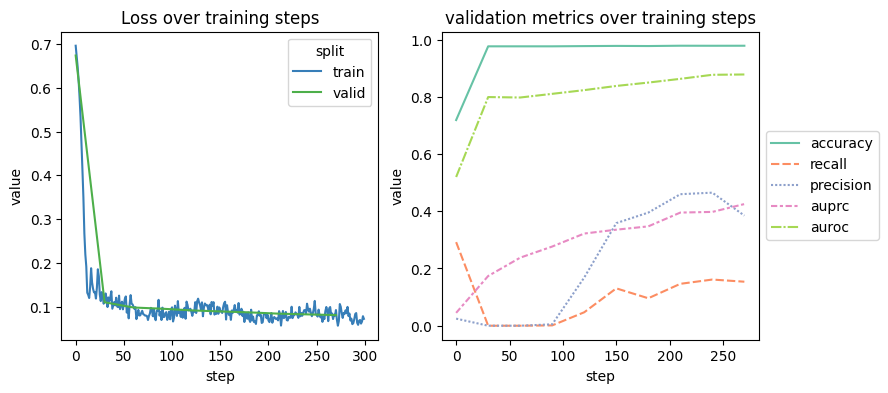

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

from dlfb.utils.metric_plots import DEFAULT_SPLIT_COLORS

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

# plot training loss curve
learning_data = pd.concat(
    pd.DataFrame(metrics[split]).melt("step").assign(split=split)
    for split in ["train", "valid"]
)

sns.lineplot(
    ax=ax[0],
    x="step",
    y="value",
    hue="split",
    data= learning_data[learning_data["variable"] == "loss"],
    palette=DEFAULT_SPLIT_COLORS,
)
ax[0].set_title("Loss over training steps")

#plot validation metrics curves
sns.lineplot(
    ax =ax[1],
    x = "step",
    y = "value",
    hue = "variable",
    style = "variable",
    data = learning_data[learning_data["variable"] != "loss"],
    palette = "Set2",
)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax[1].set_title("validation metrics over training steps")

Text(0.5, 38.444444444444436, 'Functional category')

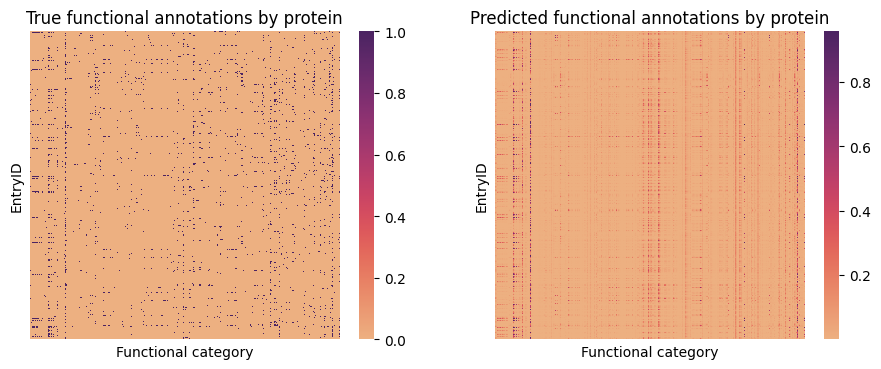

In [64]:
# examining the model predictions

valid_df = load_sequence_embeddings(
    store_file_prefix=r"C:\Users\justc\Documents\ml-study-notes\ml-study-notes\dlfb-clone\assets\proteins\datasets\protein_dataset_valid",
    model_checkpoint=model_checkpoint
)

# Use batch size of 1 to avoid dropping the remainder
valid_probs = []
for valid_batch in dataset_splits["valid"].batch(1).as_numpy_iterator():
    logits = state.apply_fn({"params": state.params}, x=valid_batch["embedding"])
    valid_probs.extend(jax.nn.sigmoid(logits))

valid_true_df = valid_df[["EntryID"] + targets].set_index('EntryID')
valid_prob_df = pd.DataFrame(
    np.stack(valid_probs), columns=targets, index=valid_true_df.index
)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11, 4))

sns.heatmap(
    ax=ax[0],
    data=valid_true_df,
    yticklabels=False,
    xticklabels=False,
    cmap="flare",
)
ax[0].set_title("True functional annotations by protein")
ax[0].set_xlabel("Functional category")

sns.heatmap(
    ax=ax[1],
    data=valid_prob_df,
    yticklabels=False,
    xticklabels=False,
    cmap="flare",
)
ax[1].set_title("Predicted functional annotations by protein")
ax[1].set_xlabel("Functional category")


1. Some protein functions appear frequently in the dataset (visible as vertial stripes), and the model tends to predict these relatively well.
2. Rare functions are harder to capture - the model often misses them entirely, leading to sparse or empty columns in the predicted heatmap.
3. A few functions are over-predicted, visible as faint vertical lines across many proteins, suggesting the model is overly confident for those categories
4. Many cells in the predicted matrix show intermediate color tones, which reflect more uncertain probabilities (not a confident near-0 or near-1).

In [ ]:

metrics_by_function = {}
for function in targets:
    metrics_by_function[function] = compute_metrics(
        valid_true_df[function].values, valid_prob_df[function].values # pyright: ignore[reportArgumentType]
    )

overview_valid = (
    pd.DataFrame(metrics_by_function)
    .T.merge(go_term_descriptions, left_index=True, right_on='term')
    .set_index("term")
    .sort_values("auprc", ascending=False)
)
print(overview_valid)

            accuracy    recall  precision     auprc     auroc  \
term                                                            
GO:0004930  0.958858  0.000000   0.000000  0.946423  0.982058   
GO:0004888  0.956339  0.341772   1.000000  0.849384  0.969072   
GO:0003824  0.850546  0.771971   0.798526  0.848323  0.908107   
GO:1990837  0.952141  0.495146   0.910714  0.828098  0.970918   
GO:0043565  0.957179  0.640351   0.879518  0.826699  0.964269   
...              ...       ...        ...       ...       ...   
GO:0004714  0.999160  0.000000   0.000000  0.001248  0.327731   
GO:0042626  0.000000  0.000000   0.000000  0.000000  0.000000   
GO:0051015  0.000000  0.000000   0.000000  0.000000  0.000000   
GO:0003774  0.000000  0.000000   0.000000  0.000000  0.000000   
GO:1902936  0.000000  0.000000   0.000000  0.000000  0.000000   

                                                  description  
term                                                           
GO:0004930                

In [75]:
overview_valid = overview_valid.merge(
    pd.DataFrame(train_df[targets].sum(), columns=["train_n"]),
    left_index=True,
    right_index=True,
)
print(overview_valid)

            accuracy    recall  precision     auprc     auroc  \
GO:0004930  0.958858  0.000000   0.000000  0.946423  0.982058   
GO:0004888  0.956339  0.341772   1.000000  0.849384  0.969072   
GO:0003824  0.850546  0.771971   0.798526  0.848323  0.908107   
GO:1990837  0.952141  0.495146   0.910714  0.828098  0.970918   
GO:0043565  0.957179  0.640351   0.879518  0.826699  0.964269   
...              ...       ...        ...       ...       ...   
GO:0004714  0.999160  0.000000   0.000000  0.001248  0.327731   
GO:0042626  0.000000  0.000000   0.000000  0.000000  0.000000   
GO:0051015  0.000000  0.000000   0.000000  0.000000  0.000000   
GO:0003774  0.000000  0.000000   0.000000  0.000000  0.000000   
GO:1902936  0.000000  0.000000   0.000000  0.000000  0.000000   

                                                  description  train_n  
GO:0004930                G protein-coupled receptor activity      138  
GO:0004888          transmembrane signaling receptor activity      228  


Text(0, 0.5, 'Validation auPRC')

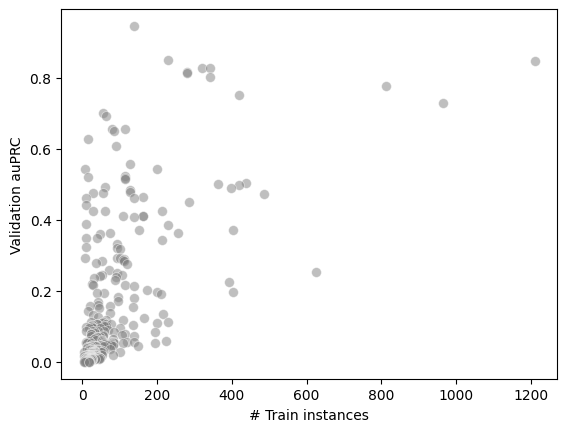

In [76]:
fig = sns.scatterplot(
    x="train_n", y="auprc", data=overview_valid, alpha=0.5, s=50, color="grey"
)
fig.set_xlabel("# Train instances")
fig.set_ylabel("Validation auPRC")

above chart shows that the higher the frequency of occurence in the training set, the more accurate prediction is made by the model! (auPRC)

# Evaluating Model Usefulness: coin flip, proportional guessing

In [79]:
def make_coin_flip_predictions(
    valid_true_df: pd.DataFrame, targets: list[str]
) -> pd.DataFrame:
    """make random coin flip predictions for each protein functon."""
    predictions = np.random.choice([0.0, 1.0], size=valid_true_df.shape)
    return pd.DataFrame(predictions, columns=targets, index=valid_true_df.index) # pyright: ignore[reportCallIssue]

def make_proportional_predictions(
    valid_true_df: pd.DataFrame, train_df: pd.DataFrame, targets: list[str]
) -> pd.DataFrame:
    """make random protein function predictions proportional to frequency"""
    percent_1_train = dict(train_df[targets].mean())
    proportional_preds = []
    for target_column in targets:
        prob_1 = percent_1_train[target_column]
        prob_0 = 1 - prob_1
        proportional_preds.append(
            np.random.choice([0.0, 1.0], size=len(valid_true_df), p=[prob_0, prob_1])
        )
    return pd.DataFrame(
        np.stack(proportional_preds).T, columns=targets, index=valid_true_df.index
    )

In [ ]:
prediction_methods = {
    "coin_flip_baseline" : make_coin_flip_predictions(valid_true_df, targets),
    "proportional_guess_baseline": make_proportional_predictions(
        valid_true_df, train_df, targets
    ),
    "model": valid_prob_df,
}
metrics_by_method = {}
for method, preds_df in prediction_methods.items():
    metrics_by_method[method] = pd.DataFrame(
        [
            compute_metrics(valid_true_df.iloc[i], preds_df.iloc[i]) # pyright: ignore[reportArgumentType]
            for i in range(len(valid_true_df))
        ]
    ).mean()
print(pd.DataFrame(metrics_by_method))

           coin_flip_baseline  proportional_guess_baseline     model
accuracy             0.499827                     0.956808  0.978577
recall               0.497670                     0.092488  0.138217
precision            0.023599                     0.084477  0.449274
auprc                0.025135                     0.039527  0.413840
auroc                0.498735                     0.535216  0.882254


In [ ]:
auprc_by_function = {}

for method, preds_df in prediction_methods.items():
    metrics_by_function = {}
    
    for function in targets:
        metrics_by_function[function] = compute_metrics(
            valid_true_df[function], preds_df[function] # pyright: ignore[reportArgumentType]
        )
    auprc_by_function[method] = (
        pd.DataFrame(metrics_by_function)
        .T.merge(go_term_descriptions, left_index=True, right_on="term")
        .set_index("term")
        .sort_values("auprc", ascending=False)
    )["auprc"].to_dict()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'G protein-coupled receptor activity'),
  Text(1, 0, 'transmembrane signaling receptor activity'),
  Text(2, 0, 'catalytic activity'),
  Text(3, 0, 'sequence-specific double-stranded DNA binding'),
  Text(4, 0, 'sequence-specific DNA binding'),
  Text(5, 0, 'molecular transducer activity'),
  Text(6, 0, 'signaling receptor activity'),
  Text(7, 0, 'double-stranded DNA binding'),
  Text(8, 0, 'nucleic acid binding'),
  Text(9, 0, 'DNA binding'),
  Text(10, 0, 'heterocyclic compound binding'),
  Text(11, 0, 'G protein-coupled peptide receptor activity'),
  Text(12, 0, 'protein serine/threonine kinase activity'),
  Text(13, 0, 'GTPase activity'),
  Text(14, 0, 'phosphotransferase activity, alcohol group as acceptor'),
  Text(15, 0, 'protein kinase activity'),
  Text(16, 0, 'extracellular ligand-gated monoatomic ion channel activity'),
  Text(17, 0, 'ribonucleoside triphosphate phosphatase activity'),
  T

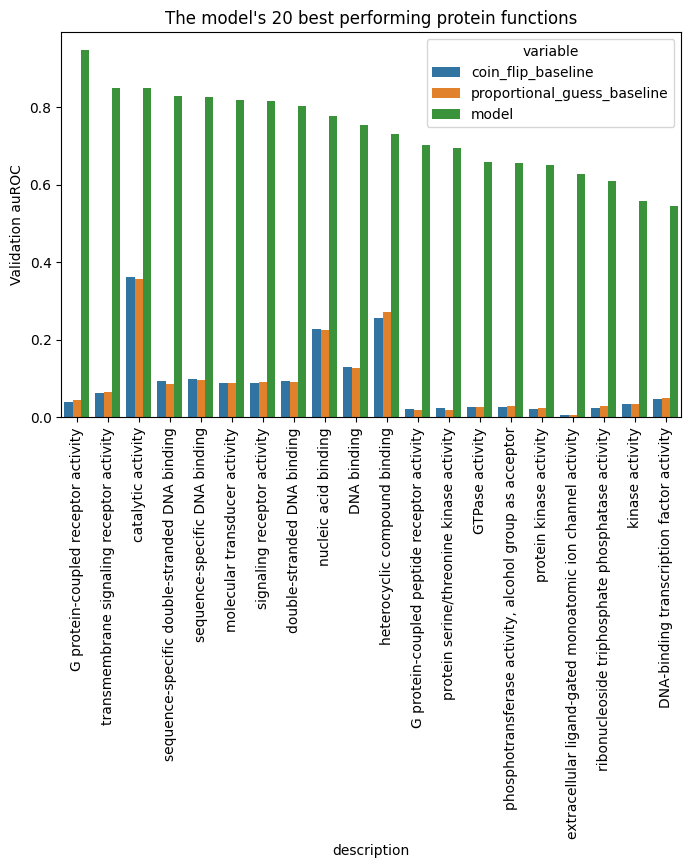

In [83]:
best_performing = (
    pd.DataFrame(auprc_by_function)
    .merge(go_term_descriptions, left_index=True, right_on="term")
    .set_index("term")
    .sort_values("model", ascending=False)
    .head(20)
    .melt("description")
)

fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(
    x="description",
    y="value",
    hue="variable",
    data=best_performing,
)
ax.set_title("The model's 20 best performing protein functions")
ax.set_ylabel("Validation auROC")
plt.xticks(rotation=90)

# Conducting a final check on the test set

In [84]:
eval_metrics = []

for split in ["valid", "test"]:
    split_metrics = []

    for eval_batch in dataset_splits[split].batch(32).as_numpy_iterator():
        split_metrics.append(eval_step(state, eval_batch))

    eval_metrics.append(
        {"split": split, **pd.DataFrame(split_metrics).mean(axis=0).to_dict()}
    )
print(pd.DataFrame(eval_metrics))

   split      loss  accuracy    recall  precision     auprc     auroc
0  valid  0.080005  0.978465  0.136354   0.442975  0.413090  0.880503
1   test  0.080565  0.978027  0.135463   0.461703  0.411551  0.878022
